In [220]:
import networkx as nx
from networkx.readwrite.gml import write_gml, read_gml
from networkx.readwrite.graphml import write_graphml, read_graphml
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import lukes_partitioning
from tabulate import tabulate
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import collections
import powerlaw
import sys

In [3]:
def create_network(year):
    #Load data set
    with open(f"data/courses_{year}.json","r") as f:
        courses = json.load(f)
    #Build network    
    
    G = nx.Graph(year=year)
    for c in courses:
        if c["grade"]>0:
            G.add_node(f'{c["faculty"]["code"]}_{c["code"]}',name=c["name"],
                       faculty_name=c["faculty"]["name"],faculty_type=c["faculty"]["type"],
                       candidates=c["candidates"],accepted=c["Accepted"],vagas=c["vagas"],grade=c["grade"])
    #Drop isolates
    G.remove_nodes_from(list(nx.isolates(G)))
    for c in courses:
        for code in c["edges"].keys():
            G.add_edge(f'{c["faculty"]["code"]}_{c["code"]}',code,weight = c["edges"][code],weight_1 = 1/c["edges"][code])
    return G

In [4]:
def export_network(G):
    if year := G.graph["year"]:
        write_graphml(G,f"networks/graph_{year}.graphml")

In [130]:
G = create_network(2018)
export_network(G)

In [131]:
H = create_network(2019)
export_network(H)

In [132]:
I = create_network(2020)
export_network(I)

In [133]:
J = create_network(2021)
export_network(J)

In [12]:
def plot_degree_distribution(G):
    degrees = [G.degree(n, weight='weight') for n in G.nodes()]
    #print(len(degrees))
    plt.hist(degrees, bins=int(1+3.322*math.log(len(G.nodes())))) #Sturge's rule for number of bins
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.show()

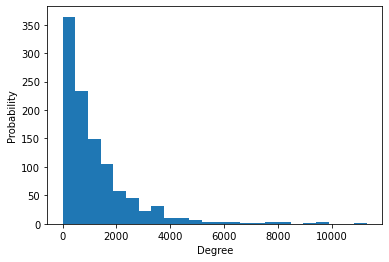

In [135]:
plot_degree_distribution(G)

In [259]:

def degree_distribution_prob(LG, cdf = False, ax=None):
    colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
    
    for i in range(len(LG)):
        degree_sequence = sorted([d for n, d in LG[i].degree(weight='weight')], reverse=True)  # degree sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())
        if cdf:
            cnt = np.cumsum(cnt)
        frac = [n/LG[i].number_of_nodes() for n in cnt]
        ax.plot(deg, frac, 'o', markersize=2, c=colors[i])
    
    ax.set(xscale='linear', yscale='log', xlabel="$k$", ylabel="$P_{cum}(k)$", 
           xlim=(0,ax.get_xlim()[1]))
    #plt.plot(deg, frac, 'o')
    #ax.xscale("linear")
    #ax.yscale("log")
#    ax.ylabel("$P_{cum}(k)$")
#    ax.xlabel("$k$")
    ax.grid()
    plt.rcParams.update({'font.size': 6})
    plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=6)    
    plt.rc('axes', titlesize=6)  
    ax.legend(["2018", "2019", "2020", "2021"]) #update title
    plt.tight_layout()
    plt.savefig('deg_distribution.pdf')

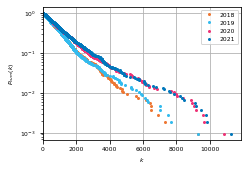

In [265]:
LG = [G, H, I, J]
cm = 1/2.54
fig ,ax = plt.subplots(figsize=(8.7*cm, 6*cm))
degree_distribution_prob(LG,  cdf=True, ax=ax)

In [83]:
def powerlaw_fit(LG):
    plt.figure(figsize=(10, 6))
    plt.xticks()
    plt.yticks()
    for i in range(len(LG)):
        degree_sequence = sorted([d for n, d in LG[i].degree(weight='weight')], reverse=True)  # degree sequence
        fit = powerlaw.Fit(degree_sequence, discrete = True) 
        alpha = fit.power_law.alpha #coeficiente
        print("Coef for year %d : %.4f " %(2021-i, alpha))
        fit.plot_pdf(linewidth=1)
        print("xmin : %.4f " % fit.find_xmin())
    plt.ylabel("Probability")
    plt.xlabel("Degree")
    plt.legend(["2021", "2020", "2019", "2018"]) #update title   

Calculating best minimal value for power law fit
Coef for year 2021 : 3.8330 
xmin : 3327.0000 %
Calculating best minimal value for power law fit
Coef for year 2020 : 3.0761 
xmin : 1846.0000 %
Calculating best minimal value for power law fit
Coef for year 2019 : 3.0863 
xmin : 1397.0000 %
Calculating best minimal value for power law fit
Coef for year 2018 : 3.0854 
xmin : 1318.0000 %


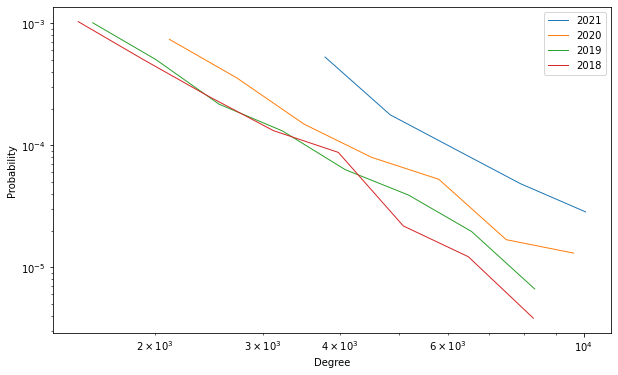

In [64]:
powerlaw_fit(LG)

In [301]:
def powerlaw_compare(G, ax=ax):
    colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
    degree_sequence = sorted([d for n, d in G.degree(weight='weight')], reverse=True)  # degree sequence
    fit = powerlaw.Fit(degree_sequence, discrete = True) 
    alpha = fit.power_law.alpha #coeficiente
    #fig = fit.plot_ccdf( linewidth=1) #plotting the powerlaw fit 
    fit.distribution_compare('power_law', 'lognormal')
    ax = fit.plot_ccdf(linewidth=3, color= colors[0], label = 'alpha')
    fit.power_law.plot_ccdf(ax=ax, color=colors[1], linestyle='--') #powerlaw
    fit.stretched_exponential.plot_ccdf(ax=ax, color=colors[2], linestyle='--') #stretched_exponential
    ax.set(xscale='log', yscale='log', xlabel="$k$", ylabel="$P_{cum}(k)$")
    plt.rcParams.update({'font.size': 6})
    plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=6)    
    plt.rc('axes', titlesize=6)  
    ax.grid(True, which = "minor")
    plt.tight_layout()
    string= "\u03B1 = %.3f " % (alpha)
    #ax.text(9*1e+3, 0.9, string, fontsize=6)
    #plt.label("$alpha$ = .4%f" & alpha)
    plt.legend(["Prob. distribution", "Powerlaw", "Stretched exp."]) #update title
    plt.savefig('2021_powerlaw.pdf')

Calculating best minimal value for power law fit


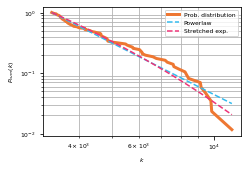

In [302]:
fig ,ax = plt.subplots(figsize=(8.7*cm, 6*cm))
powerlaw_compare(J, ax=ax)


In [ ]:
def average_degree(LG):
    av_degree=[]
    for i in range(len(LG)):
        degrees = sum([LG[i].degree(n, weight='weight') for n in LG[i].nodes()])
        n_nodes = len(LG[i].nodes())
        av_degree = np.append(av_degree, degrees/n_nodes)
    return av_degree

In [37]:
average_degree(LG)

array([1243.27511737, 1214.81091251,  962.98484848,  957.86829727])

In [24]:
%%time
nx.average_shortest_path_length(G)

KeyboardInterrupt: 

In [233]:
def comparing_clustering(LG):
    clustering=[]
    years=[]
    for i in range(len(LG)):
        clust = nx.average_clustering(LG[i])
        clustering.append(clust)
        years.append(2021-i)
    data =zip(years, clustering)
    headers=['years', 'clust coef']
    print(tabulate(data, headers= headers, tablefmt="plain"))
    return clustering

In [234]:
clust = comparing_clustering(LG)

  years    clust coef
   2021      0.436552
   2020      0.428313
   2019      0.426047
   2018      0.423836


In [49]:
len(J.nodes())

1063

In [39]:
len(G.edges())

81032

In [150]:
n_nodes = [len(graph.nodes()) for graph in LG]
n_edges = [len(graph.edges()) for graph in LG]
years = [i for i in range(2018,2022)]
av_degree =average_degree(LG)
data ={ 'Years': years, 'N nodes': n_nodes, 'N edges': n_edges, 'Average degree' : av_degree}
tab = (tabulate((data), headers='keys'))
np.save('char.txt', tab)

In [42]:
a = nx.betweenness_centrality(G, weight= 'weight')

In [43]:
G.nodes[max(a,key=a.get)],a[max(a,key=a.get)]

({}, 0.007195738855040254)

In [77]:
max_value = G.nodes[max(centrality.keys())]

In [82]:
G.nodes[max(centrality, key = centrality.get)]

{}